In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
%cd /content/drive/MyDrive/AutoSVD++

/content/drive/MyDrive/AutoSVD++


In [ ]:
!pip install result

In [ ]:
!pip install ipython-autotime
%load_ext autotime

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 7.3 MB/s eta 0:00:00
time: 365 µs (started: 2023-12-09 04:25:22 +00:00)


# Part 1 AutoSVD

First, run predict_AutoSVD.py, which loads the pretrained AutoSVD model, constructs the YelpRecommendationGenerator(), randomly selects a sample user, and generate predicted stars and top 10 recommendations for the user.

In [ ]:
!python predict_AutoSVD.py

Number of users=5913; Number of items=28028

 =============== generate sample user  Ye-9S8f2dt41UBfy4lXffA  =============== 

                    user_id   name  ...  compliment_writer compliment_photos
173  Ye-9S8f2dt41UBfy4lXffA  Tamia  ...                 36                27

[1 rows x 22 columns]

 ============ predicted ratings of sample user ============ 

       business_idx             business_id     stars
20352         20352  OxQK9EMUXqynT7dbWAP9wA  5.091546
1623           1623  ymy2ykGH2kjcPIitZQkkUg  4.963768
21386         21386  HNI6qvswn1KYybgJVqUWGg  4.950137
14589         14589  W2WSp4mAg8Z8EE_caaqx4A  4.939493
6535           6535  fq1yCVBgBB7s6V-D68NO1g  4.936649
...             ...                     ...       ...
15984         15984  xg2BYY0tswiEDz2HvTRq2w  2.091204
9972           9972  snV6gaFbAv77wApb8kUJDw  2.047444
5033           5033  F8uKZRKmdrqcQYNS9SXCWw  2.014963
4638           4638  UBj0aJ6FfMR4tdvRbQ3KSA  2.013475
17497         17497  JlaN-l82FTe4YGoz769

After a simple run test, we run experiments on the test subset generated by our group (i.e. sample_reviews.test.json). Loaded the pre-trained AutoSVD model.

In [70]:
from utils.YelpRecommendationGenerator import *
import numpy as np

autosvd = AutoSVD(path_of_feature_file="datasets/samplesets/restaurant_features_encoded.csv")
autosvd.load_model()
yelp_recommender = YelpRecommendationGenerator(autosvd)
df_user, df_business, df_review_train, df_review_test = yelp_recommender.load_sample_dataset()

time: 24.3 ms (started: 2023-12-09 05:26:38 +00:00)


Use the function of the YelpRecommendationGenerator class to predict stars for all businesses in the test set for each user. Store all predictions in test_matrix

In [72]:
test_matrix = yelp_recommender.predict_stars_for_all_users()

time: 16min 2s (started: 2023-12-09 05:26:48 +00:00)


In [76]:
file_path_npy = 'predictions/test_matrix.npy'
np.save(file_path_npy, test_matrix)

time: 12.4 s (started: 2023-12-09 05:46:53 +00:00)


In [78]:
file_path = 'predictions/test_matrix.npy'
test_matrix = np.load(file_path)

time: 1.38 s (started: 2023-12-09 05:47:20 +00:00)


Sort each row of the test_matrix (i.e. stars given by each user) in descending order.

In [80]:
sorted_test_matrix = np.sort(test_matrix, axis=1)[:, ::-1]

time: 11.3 s (started: 2023-12-09 05:48:01 +00:00)


In [81]:
sorted_test_matrix

array([[5.1965294 , 5.1067513 , 5.06692165, ..., 2.15049694, 2.13523009,
        2.12249578],
       [5.02049281, 4.95332036, 4.90115509, ..., 2.00947356, 2.00003028,
        1.97932664],
       [5.07090676, 4.77492228, 4.73835645, ..., 1.63496486, 1.5351367 ,
        1.50754095],
       ...,
       [5.29069698, 5.25109599, 5.22716134, ..., 2.38265054, 2.38099562,
        2.34917281],
       [5.60319329, 5.5987548 , 5.59344734, ..., 2.77143695, 2.75281755,
        2.73205329],
       [5.33263634, 5.30701858, 5.30025187, ..., 2.47349708, 2.46447066,
        2.44257078]])

time: 4.26 ms (started: 2023-12-09 05:48:14 +00:00)


Get the corresponding business_idx of which business is this star the user gives to.

In [82]:
sorted_indices = np.argsort(-test_matrix, axis=1)

time: 13.3 s (started: 2023-12-09 05:48:19 +00:00)


In [83]:
sorted_indices

array([[20352,  1623, 14589, ...,  9972,  5033, 17497],
       [20352,  1623, 14589, ...,  5033,  9972, 17497],
       [20352, 15382,  4014, ...,  4638,  5033, 17497],
       ...,
       [ 1623, 20352,  6535, ..., 17497,  4638,  9972],
       [ 6535,  1623,  8513, ..., 18307,  9972, 18426],
       [ 1623,  6535, 20352, ..., 18307, 18426,  9972]])

time: 3.4 ms (started: 2023-12-09 05:48:35 +00:00)


Then, we want to generate top_k accuracy of AutoSVD.

In [169]:
import pandas as pd

unique_user_ids = pd.concat([df_review_train['user_id'], df_review_test['user_id']]).unique()
unique_business_ids = pd.concat([df_review_train['business_id'], df_review_test['business_id']]).unique()
user_id_to_index = {user_id: index for index, user_id in enumerate(unique_user_ids, start=0)}
business_id_to_index = {business_id: index for index, business_id in enumerate(unique_business_ids, start=0)}
index_to_user_id = {v: k for k, v in user_id_to_index.items()}
index_to_business_id = {v: k for k, v in business_id_to_index.items()}

time: 113 ms (started: 2023-12-09 07:17:07 +00:00)


In [199]:
def get_top_k_accuracy(n):
  sum = 0
  for user_idx in range(test_matrix.shape[0]):
    user_stars = df_review_test[df_review_test['user_idx'] == user_idx]
    max_star = user_stars['stars'].max()
    highest_rated_businesses = user_stars[user_stars['stars'] == max_star]['business_idx']
    highest_rated_businesses_list = highest_rated_businesses.tolist()
    for j in range(n):
      if sorted_indices[user_idx][j] in highest_rated_businesses_list:
        sum = sum + 1
        print(f"user_idx= {user_idx}, user_id= {index_to_user_id[user_idx]}, business_id= {index_to_business_id[sorted_indices[user_idx][j]]}")
        break;

  top_k_accuracy = sum / test_matrix.shape[0]
  print(f"Number of relevant recommendations for AutoSVD: {sum}")
  print(f"Top {n} Accuracy for AutoSVD: {top_k_accuracy}")

  return top_k_accuracy

time: 841 µs (started: 2023-12-09 07:42:19 +00:00)


Top 1 accuracy

In [171]:
top_1_accuracy = get_top_k_accuracy(1)

user_idx= 4058, user_id= HxyLRaoH9PS09M6R3rV-EQ, business_id= OxQK9EMUXqynT7dbWAP9wA
Number of relevant recommendations for AutoSVD: 1
Top 1 Accuracy for AutoSVD: 0.00016911889058007779
time: 5.3 s (started: 2023-12-09 07:17:10 +00:00)


Top 5 Accuracy

In [172]:
top_5_accuracy = get_top_k_accuracy(5)

user_idx= 544, user_id= IsXy4uiCoElOhmEdLY7QTg, business_id= gvD09Ev1aOmphtlq07zYEA
user_idx= 1842, user_id= i63z952BJ-n-RFGVB7PL4w, business_id= 73ZXjIfdHJs59XOzKHQ45g
user_idx= 4058, user_id= HxyLRaoH9PS09M6R3rV-EQ, business_id= OxQK9EMUXqynT7dbWAP9wA
user_idx= 4463, user_id= yiYAbxOdApOtnxR9ORpmKw, business_id= qpLXjhAYATp_j_SBRUtjIw
Number of relevant recommendations for AutoSVD: 4
Top 5 Accuracy for AutoSVD: 0.0006764755623203111
time: 5.27 s (started: 2023-12-09 07:17:20 +00:00)


Top 10 Accuracy

In [173]:
top_10_accuracy = get_top_k_accuracy(10)

user_idx= 544, user_id= IsXy4uiCoElOhmEdLY7QTg, business_id= gvD09Ev1aOmphtlq07zYEA
user_idx= 1842, user_id= i63z952BJ-n-RFGVB7PL4w, business_id= 73ZXjIfdHJs59XOzKHQ45g
user_idx= 4058, user_id= HxyLRaoH9PS09M6R3rV-EQ, business_id= OxQK9EMUXqynT7dbWAP9wA
user_idx= 4463, user_id= yiYAbxOdApOtnxR9ORpmKw, business_id= qpLXjhAYATp_j_SBRUtjIw
Number of relevant recommendations for AutoSVD: 4
Top 10 Accuracy for AutoSVD: 0.0006764755623203111
time: 5.52 s (started: 2023-12-09 07:17:26 +00:00)


As we found out that only for user_id= HxyLRaoH9PS09M6R3rV-EQ the top-1 recommendation is relevant, we show an example prediction and top-5 recommendations for this user.

In [174]:
yelp_recommender.predict_stars_for_sample_user('HxyLRaoH9PS09M6R3rV-EQ')

,business_idx,business_id,stars
20352,20352,OxQK9EMUXqynT7dbWAP9wA,4.753577
15382,15382,ZForVw2ZTiwDGfZ0XvZsXQ,4.602638
4014,4014,TqezXFPh-f2cqIgkMvzHmQ,4.597181
21386,21386,HNI6qvswn1KYybgJVqUWGg,4.532810
16909,16909,73ZXjIfdHJs59XOzKHQ45g,4.531271
...,...,...,...
4638,4638,UBj0aJ6FfMR4tdvRbQ3KSA,1.791737
22908,22908,5ln4ESCi6mnfTBx4bYr4dw,1.784402
5033,5033,F8uKZRKmdrqcQYNS9SXCWw,1.713669
15984,15984,xg2BYY0tswiEDz2HvTRq2w,1.679226


time: 1.49 s (started: 2023-12-09 07:18:11 +00:00)


In [175]:
yelp_recommender.generate_top_k_recommendations(user_id='HxyLRaoH9PS09M6R3rV-EQ',k=5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,OxQK9EMUXqynT7dbWAP9wA,Mission BBQ,11000 Roosevelt Blvd,Philadelphia,PA,19116,40.100552,-75.009254,4.0,242,1,"{'RestaurantsTakeOut': 'True', 'NoiseLevel': '...","American (New), Barbeque, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."
1,ZForVw2ZTiwDGfZ0XvZsXQ,Uncle Bobbie's Coffee & Books,5445 Germantown Ave,Philadelphia,PA,19144,40.034015,-75.171844,4.5,151,1,"{'BikeParking': 'True', 'BusinessAcceptsBitcoi...","Cafes, Restaurants, Shopping, Food, Books, Mag...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-19:0', '..."
2,TqezXFPh-f2cqIgkMvzHmQ,Sierra Gold Seafood,"1335 Greg St, Ste 105",Sparks,NV,89431,39.520810,-119.760232,5.0,95,1,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...","Grocery, Specialty Food, Restaurants, Food, Se...","{'Tuesday': '10:0-18:0', 'Wednesday': '10:0-18..."
3,HNI6qvswn1KYybgJVqUWGg,Marinucci's Deli - Mayfair,2852 Saint Vincent St,Philadelphia,PA,19149,40.041504,-75.054122,4.5,130,1,"{'WiFi': ''no'', 'Alcohol': 'u'none'', 'Busine...","Delis, Restaurants","{'Monday': '9:0-18:0', 'Tuesday': '9:0-18:0', ..."
4,73ZXjIfdHJs59XOzKHQ45g,The Crossing,7823 Forsyth Blvd,Clayton,MO,63105,38.650409,-90.337814,4.5,208,1,"{'RestaurantsReservations': 'True', 'BusinessA...","French, Restaurants, American (New), Italian","{'Monday': '17:0-22:0', 'Tuesday': '17:0-22:0'..."


time: 1.57 s (started: 2023-12-09 07:19:17 +00:00)


Finally, we generated top_k accuracies, where k ranges from 1 to 100 (step=5).

In [205]:
import contextlib
import io
import sys

top_k_accuracies = []
for i in np.arange(0, 100, 5):
  if i == 0:
    i = 1
  with contextlib.redirect_stdout(io.StringIO()):
    top_k_accuracy = get_top_k_accuracy(i)
  top_k_accuracies.append(top_k_accuracy)

time: 1min 48s (started: 2023-12-09 07:49:58 +00:00)


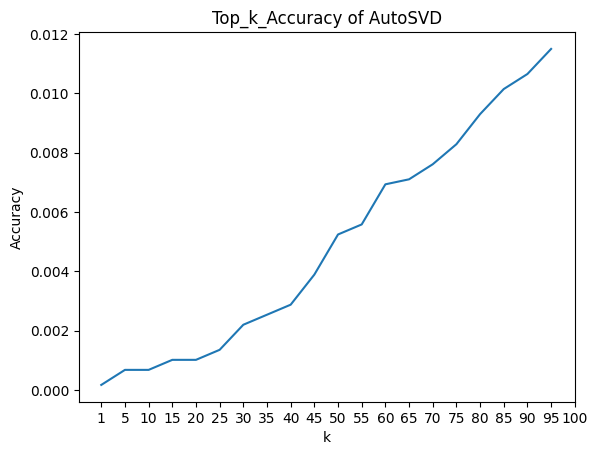

time: 208 ms (started: 2023-12-09 08:00:20 +00:00)


In [210]:
import matplotlib.pyplot as plt

x_points = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

# Plotting the NumPy array as a line plot
plt.plot(top_k_accuracies)
plt.xticks(x_points, ['1', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50',
                      '55', '60', '65', '70', '75', '80', '85', '90', '95', '100'])
plt.title('Top_k_Accuracy of AutoSVD')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()

# Part 2 AutoSVD++

Similar to AutoSVD, run predict_AutoSVDpp.py, which loads the pretrained AutoSVDpp model, constructs the YelpRecommendationGenerator(), randomly selects a sample user, and generate predicted stars and top 10 recommendations for the user.

In [ ]:
!python predict_AutoSVDpp.py

Number of users=5913; Number of items=28028

 =============== generate sample user  Ye-9S8f2dt41UBfy4lXffA  =============== 

                    user_id   name  ...  compliment_writer compliment_photos
173  Ye-9S8f2dt41UBfy4lXffA  Tamia  ...                 36                27

[1 rows x 22 columns]

 ====================== predicted ratings of sample user ====================== 

       business_idx             business_id     stars
20352         20352  OxQK9EMUXqynT7dbWAP9wA  5.078019
21386         21386  HNI6qvswn1KYybgJVqUWGg  4.988201
4014           4014  TqezXFPh-f2cqIgkMvzHmQ  4.979134
15382         15382  ZForVw2ZTiwDGfZ0XvZsXQ  4.966298
16909         16909  73ZXjIfdHJs59XOzKHQ45g  4.929737
...             ...                     ...       ...
9972           9972  snV6gaFbAv77wApb8kUJDw  2.269753
4638           4638  UBj0aJ6FfMR4tdvRbQ3KSA  2.258521
5033           5033  F8uKZRKmdrqcQYNS9SXCWw  2.258410
15984         15984  xg2BYY0tswiEDz2HvTRq2w  2.243474
17497         17497 

After a simple run test, we run experiments on the test subset generated by our group (i.e. sample_reviews.test.json). Loaded the pre-trained AutoSVDpp model.

In [216]:
from models.AutoSVDpp import AutoSVDpp
from utils.YelpRecommendationGenerator import *

autosvdpp = AutoSVDpp(path_of_feature_file="datasets/samplesets/restaurant_features_encoded.csv")
autosvdpp.load_model()
yelp_recommender = YelpRecommendationGenerator(autosvdpp)
df_user, df_business, df_review_train, df_review_test= yelp_recommender.load_sample_dataset()

Number of users=5913; Number of items=28028
time: 3.4 s (started: 2023-12-09 08:06:06 +00:00)


Use the function of the YelpRecommendationGenerator class to predict stars for all businesses in the test set for each user. Store all predictions in test_matrix_pp

In [120]:
test_matrix_pp = yelp_recommender.predict_stars_for_all_users()

time: 15min 13s (started: 2023-12-09 06:19:56 +00:00)


In [121]:
file_path_npy = 'predictions/test_matrix_pp.npy'
np.save(file_path_npy, test_matrix_pp)

time: 2.14 s (started: 2023-12-09 06:35:30 +00:00)


In [132]:
file_path = 'predictions/test_matrix_pp.npy'
test_matrix_pp = np.load(file_path)

time: 1.32 s (started: 2023-12-09 06:52:05 +00:00)


Sort each row of the test_matrix (i.e. stars given by each user) in descending order.

In [133]:
sorted_test_matrix_pp = np.sort(test_matrix_pp, axis=1)[:, ::-1]

time: 11.4 s (started: 2023-12-09 06:52:17 +00:00)


In [134]:
sorted_test_matrix_pp

array([[5.16172328, 5.08380123, 5.06317626, ..., 2.32119738, 2.31381854,
        2.20197962],
       [5.00667787, 4.95479356, 4.91185414, ..., 2.18467128, 2.17451035,
        2.07042676],
       [4.95646797, 4.7973268 , 4.74170416, ..., 1.82847664, 1.81271733,
        1.66065106],
       ...,
       [5.28579011, 5.27488675, 5.26441772, ..., 2.60383382, 2.5852308 ,
        2.50072854],
       [5.64725708, 5.64222165, 5.63658942, ..., 3.05828799, 3.02189432,
        2.9733297 ],
       [5.28035129, 5.27236582, 5.27004721, ..., 2.61265209, 2.60199997,
        2.51250575]])

time: 3.65 ms (started: 2023-12-09 06:53:17 +00:00)


Get the corresponding business_idx of which business is this star the user gives to.

In [136]:
sorted_indices_pp = np.argsort(-test_matrix_pp, axis=1)

time: 13.6 s (started: 2023-12-09 06:56:12 +00:00)


In [137]:
sorted_indices_pp

array([[20352, 15382, 21386, ..., 15984, 22908, 17497],
       [20352, 15382, 16909, ..., 22908, 15984, 17497],
       [20352, 15382,  4014, ..., 15984,  5033, 17497],
       ...,
       [20352, 21386, 15382, ...,  9972, 15984, 17497],
       [ 1463, 21386, 17878, ..., 15984,  9972, 17497],
       [20352, 21386, 15382, ...,  9972, 15984, 17497]])

time: 3.4 ms (started: 2023-12-09 06:56:50 +00:00)


Then, we want to generate top_k accuracy of AutoSVDpp.

In [219]:
def get_top_k_accuracy_pp(n):
  sum = 0
  for user_idx in range(test_matrix_pp.shape[0]):
    user_stars = df_review_test[df_review_test['user_idx'] == user_idx]
    max_star = user_stars['stars'].max()
    highest_rated_businesses = user_stars[user_stars['stars'] == max_star]['business_idx']
    highest_rated_businesses_list = highest_rated_businesses.tolist()
    for j in range(n):
      if sorted_indices_pp[user_idx][j] in highest_rated_businesses_list:
        sum = sum + 1
        print(f"user_idx= {user_idx}, user_id= {index_to_user_id[user_idx]}, business_id= {index_to_business_id[sorted_indices_pp[user_idx][j]]}")
        break;

  top_k_accuracy = sum / test_matrix_pp.shape[0]
  print(f"Number of relevant recommendations for AutoSVDpp: {sum}:")
  print(f"Top {n} Accuracy for AutoSVDpp: {top_k_accuracy}:")

  return top_k_accuracy

time: 849 µs (started: 2023-12-09 08:07:54 +00:00)


Top 1 Accuracy

In [220]:
top_1_accuracy = get_top_k_accuracy_pp(1)

user_idx= 4058, user_id= HxyLRaoH9PS09M6R3rV-EQ, business_id= OxQK9EMUXqynT7dbWAP9wA
Number of relevant recommendations for AutoSVDpp: 1:
Top 1 Accuracy for AutoSVDpp: 0.00016911889058007779:
time: 5.32 s (started: 2023-12-09 08:07:56 +00:00)


Top 5 Accuracy

In [221]:
top_5_accuracy = get_top_k_accuracy_pp(5)

user_idx= 1842, user_id= i63z952BJ-n-RFGVB7PL4w, business_id= 73ZXjIfdHJs59XOzKHQ45g
user_idx= 4058, user_id= HxyLRaoH9PS09M6R3rV-EQ, business_id= OxQK9EMUXqynT7dbWAP9wA
user_idx= 4075, user_id= EDme-VW0ivgMMThQARlM8g, business_id= HNI6qvswn1KYybgJVqUWGg
Number of relevant recommendations for AutoSVDpp: 3:
Top 5 Accuracy for AutoSVDpp: 0.0005073566717402334:
time: 5.45 s (started: 2023-12-09 08:08:03 +00:00)


Top 10 Accuracy

In [222]:
top_10_accuracy = get_top_k_accuracy_pp(10)

user_idx= 176, user_id= A47qUdiTjcmI38rRQ69O6Q, business_id= pdh91rffpM9QptHSXjJFVQ
user_idx= 544, user_id= IsXy4uiCoElOhmEdLY7QTg, business_id= gvD09Ev1aOmphtlq07zYEA
user_idx= 1842, user_id= i63z952BJ-n-RFGVB7PL4w, business_id= 73ZXjIfdHJs59XOzKHQ45g
user_idx= 4058, user_id= HxyLRaoH9PS09M6R3rV-EQ, business_id= OxQK9EMUXqynT7dbWAP9wA
user_idx= 4075, user_id= EDme-VW0ivgMMThQARlM8g, business_id= HNI6qvswn1KYybgJVqUWGg
user_idx= 5752, user_id= Ptd9RhRyZoNHjiY1vh1A0A, business_id= HNI6qvswn1KYybgJVqUWGg
Number of relevant recommendations for AutoSVDpp: 6:
Top 10 Accuracy for AutoSVDpp: 0.0010147133434804667:
time: 5.24 s (started: 2023-12-09 08:08:10 +00:00)


Similar to the case of AutoSVD, only for user_id= HxyLRaoH9PS09M6R3rV-EQ the top-1 recommendation is relevant, we show an example prediction and top-5 recommendations for this user.

In [217]:
yelp_recommender.predict_stars_for_sample_user('HxyLRaoH9PS09M6R3rV-EQ')

,business_idx,business_id,stars
20352,20352,OxQK9EMUXqynT7dbWAP9wA,4.753577
15382,15382,ZForVw2ZTiwDGfZ0XvZsXQ,4.602638
4014,4014,TqezXFPh-f2cqIgkMvzHmQ,4.597181
21386,21386,HNI6qvswn1KYybgJVqUWGg,4.532810
16909,16909,73ZXjIfdHJs59XOzKHQ45g,4.531271
...,...,...,...
4638,4638,UBj0aJ6FfMR4tdvRbQ3KSA,1.791737
22908,22908,5ln4ESCi6mnfTBx4bYr4dw,1.784402
5033,5033,F8uKZRKmdrqcQYNS9SXCWw,1.713669
15984,15984,xg2BYY0tswiEDz2HvTRq2w,1.679226


time: 1.32 s (started: 2023-12-09 08:06:40 +00:00)


In [218]:
yelp_recommender.generate_top_k_recommendations(user_id='HxyLRaoH9PS09M6R3rV-EQ',k=5)

,business_id,name,address,city,state,postal_code,latitude,longitude,stars,review_count,is_open,attributes,categories,hours
0,OxQK9EMUXqynT7dbWAP9wA,Mission BBQ,11000 Roosevelt Blvd,Philadelphia,PA,19116,40.100552,-75.009254,4.0,242,1,"{'RestaurantsTakeOut': 'True', 'NoiseLevel': '...","American (New), Barbeque, Restaurants","{'Monday': '11:0-21:0', 'Tuesday': '11:0-21:0'..."
1,ZForVw2ZTiwDGfZ0XvZsXQ,Uncle Bobbie's Coffee & Books,5445 Germantown Ave,Philadelphia,PA,19144,40.034015,-75.171844,4.5,151,1,"{'BikeParking': 'True', 'BusinessAcceptsBitcoi...","Cafes, Restaurants, Shopping, Food, Books, Mag...","{'Monday': '0:0-0:0', 'Tuesday': '7:0-19:0', '..."
2,TqezXFPh-f2cqIgkMvzHmQ,Sierra Gold Seafood,"1335 Greg St, Ste 105",Sparks,NV,89431,39.520810,-119.760232,5.0,95,1,"{'RestaurantsPriceRange2': '2', 'BusinessAccep...","Grocery, Specialty Food, Restaurants, Food, Se...","{'Tuesday': '10:0-18:0', 'Wednesday': '10:0-18..."
3,HNI6qvswn1KYybgJVqUWGg,Marinucci's Deli - Mayfair,2852 Saint Vincent St,Philadelphia,PA,19149,40.041504,-75.054122,4.5,130,1,"{'WiFi': ''no'', 'Alcohol': 'u'none'', 'Busine...","Delis, Restaurants","{'Monday': '9:0-18:0', 'Tuesday': '9:0-18:0', ..."
4,73ZXjIfdHJs59XOzKHQ45g,The Crossing,7823 Forsyth Blvd,Clayton,MO,63105,38.650409,-90.337814,4.5,208,1,"{'RestaurantsReservations': 'True', 'BusinessA...","French, Restaurants, American (New), Italian","{'Monday': '17:0-22:0', 'Tuesday': '17:0-22:0'..."


time: 1.43 s (started: 2023-12-09 08:06:55 +00:00)


Finally, we generated top_k accuracies, where k ranges from 1 to 100 (step=5).

In [223]:
import contextlib
import io
import sys

top_k_accuracies = []
for i in np.arange(0, 100, 5):
  if i == 0:
    i = 1
  with contextlib.redirect_stdout(io.StringIO()):
    top_k_accuracy = get_top_k_accuracy_pp(i)
  top_k_accuracies.append(top_k_accuracy)

time: 1min 48s (started: 2023-12-09 08:08:23 +00:00)


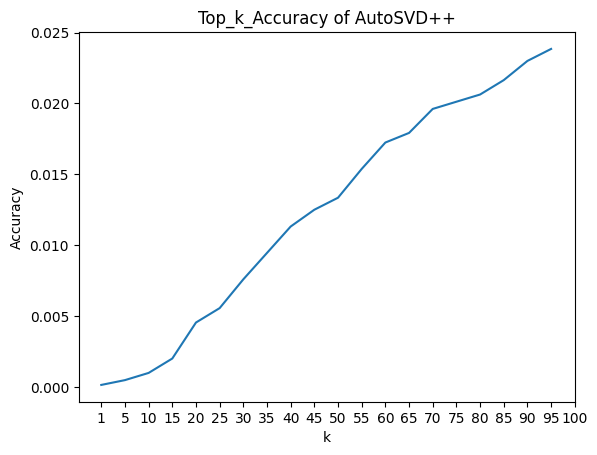

time: 199 ms (started: 2023-12-09 08:10:15 +00:00)


In [224]:
import matplotlib.pyplot as plt

x_points = [0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20]

# Plotting the NumPy array as a line plot
plt.plot(top_k_accuracies)
plt.xticks(x_points, ['1', '5', '10', '15', '20', '25', '30', '35', '40', '45', '50',
                      '55', '60', '65', '70', '75', '80', '85', '90', '95', '100'])
plt.title('Top_k_Accuracy of AutoSVD++')
plt.xlabel('k')
plt.ylabel('Accuracy')
plt.show()